In [5]:
import numpy as np
import random
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
import sklearn
import pandas as pd

In [42]:
# Load UCI breast cancer dataset with column names and remove ID column
uci_bc_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", 
    sep=",",
    header=None,
    names=[
        "id_number", "diagnosis", "radius_mean",
        "texture_mean", "perimeter_mean", "area_mean",
        "smoothness_mean", "compactness_mean",
        "concavity_mean","concave_points_mean",
        "symmetry_mean", "fractal_dimension_mean",
        "radius_se", "texture_se", "perimeter_se",
        "area_se", "smoothness_se", "compactness_se",
        "concavity_se", "concave_points_se",
        "symmetry_se", "fractal_dimension_se",
        "radius_worst", "texture_worst",
        "perimeter_worst", "area_worst",
        "smoothness_worst", "compactness_worst",
        "concavity_worst", "concave_points_worst",
        "symmetry_worst", "fractal_dimension_worst"
    ],).drop("id_number", axis=1)

y = uci_bc_data.diagnosis.map({"B": 0, "M": 1}).to_numpy()
X = uci_bc_data.drop("diagnosis", axis=1).to_numpy()

verbose = 0
if verbose:
    for i in range(31):
        print('Feature {} in range {}:{}'.format(i, np.amin(X[:,i]), np.amax(X[:,i])))

    print(len(np.argwhere(y == 0)))
    print(len(np.argwhere(y == 1)))


### Data information
The features are numerical. There are 569 samples with 30 features. The classes are binary (0 or 1). 

Highly varying scales (feature 9 is in range (0.001, 0.02), while feature 23 is in range (185, 4254)) -> should be scaled and centered.

Slightly imbalanced -> 357 0s and 212 1s.

### Rescale and center

In [88]:
Xmax = np.amax(X,0)
Xmin = np.amin(X,0)
Xmean = np.mean(X,0)
Xnew = (X-Xmin)/(Xmax - Xmin)*2 - 1

verbose = 0
if verbose:
    for i in range(31):
        print('Feature {} in range {}:{}'.format(i, np.amin(Xnew[:,i]), np.amax(Xnew[:,i])))


In [140]:
df = pd.DataFrame(Xnew)
correlation_matrix = np.array(df.corr())
verbose = 0
if verbose:
    corr = df.corr()
    plt.matshow(df.corr())
    plt.show()


### Correlation
Some of the features are highly correlated. The reason for this is biological, as features like radius, perimeter, and area must be highly correlated. 

Ground correlation matrix:


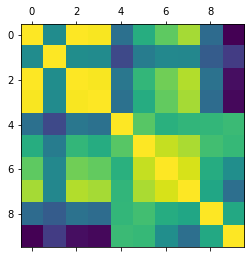

Estimated correlation matrix for class label 0:


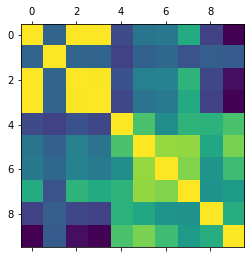

Estimated correlation matrix for class label 1:


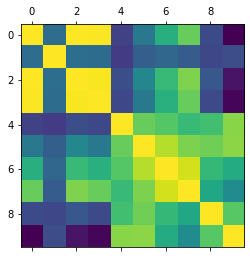

In [142]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf = QuadraticDiscriminantAnalysis(store_covariance = True)
clf.fit(X,y)
covariance_est = clf.covariance_
correlation_est_0 = get_correlation_matrix(clf.covariance_[0])
correlation_est_1 = get_correlation_matrix(clf.covariance_[1])
print('Ground correlation matrix:')
plt.matshow(correlation_matrix[:10,:10])
plt.show()
print('Estimated correlation matrix for class label 0:')
plt.matshow(correlation_est_0[:10,:10])
plt.show()
print('Estimated correlation matrix for class label 1:')
plt.matshow(correlation_est_1[:10,:10])
plt.show()


def get_correlation_matrix(cov_matrix):
    diag = np.diag(cov_matrix)
    diag = np.sqrt(1/diag)
    D = np.diag(diag)
    correlation_matrix = D@cov_matrix@D
    return correlation_matrix

In [196]:
indices = list(range(len(y)))
random.shuffle(indices)
split_index = int(0.8*len(y))
train_indices = indices[:split_index]
test_indices = indices[split_index:]
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [197]:
fit = QuadraticDiscriminantAnalysis(store_covariance = True)
fit.fit(X_train,y_train)
y_pred = fit.predict(X_test)

In [201]:
TP = np.sum(np.logical_and(y_pred, y_test))
TN = np.sum(np.logical_and(y_pred == 0, y_test == 0))
FP = np.sum(np.logical_and(y_pred, y_test == 0))
FN = np.sum(np.logical_and(y_pred == 0, y_test))

T = TP+TN+FP+FN
TP = TP/T
TN = TN/T
FP = FP/T
FN = FN/T
T = 1


accuracy = (TP + TN)/T
recall = (TP)/(TP+FN)
specificity = TN/(TN+FP)
precision = TP/(TP + FP)
F1 = 2*precision*recall/(precision + recall)
MCC = (TP*TN - FP*FN)/(np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)))

print('Accuracy is {:.2f}.'.format(accuracy))
print('Recall is {:.2f}.'.format(recall))
print('Specificity is {:.2f}.'.format(specificity))
print('Precision is {:.2f}.'.format(precision))
print('F1 is {:.2f}.'.format(F1))
print('MCC is {:.2f}.'.format(MCC))

Accuracy is 0.93.
Recall is 0.91.
Specificity is 0.94.
Precision is 0.91.
F1 is 0.91.
MCC is 0.85.


### Metric choice
Recall is a good classification metric, as it is more important to detect positives than negatives.